# Regressor Extraction
Im this notebook we extract our target confounds used for the study. These are taken from the fmriprep confound files.  

The confounds this notebook currently extracts are: 6 basic head motion params (mocos), framewise (FD) spikes, aCompCor0-5

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>


### Data Setup

In [2]:
import os, glob
import pandas as pd
from IPython.display import display
from IPython.core import display as ICD
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
from IPython.display import SVG, display
import subprocess
import numpy as np
from multiprocessing import Pool
import time
from openpyxl import load_workbook
import subprocess as sp


%matplotlib inline

pd.set_option('display.max_rows', None)


In [3]:
bbx_path='/projects/niblab/experiments/bbx'
datapath='/projects/niblab/experiments/bbx/data'
fmriprep_path='/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0'
confound_path='/projects/niblab/experiments/bbx/data/preprocessed/confounds_trimmed'
bids_path='/projects/niblab/experiments/bbx/data/bids/bids_trimmed'




In [4]:
remove_subs=['sub-029', 'sub-047', 'sub-049', 'sub-069', 'sub-081', 'sub-094', 'sub-101',
             'sub-105', 'sub-106', 'sub-110', 'sub-113', 'sub-122', 'sub-125', 'sub-126', 
             'sub-139', 'sub-155', 'sub-158', 'sub-165']

s2_drop_subjects=["sub-003", 'sub-012','sub-016', 'sub-018',  "sub-020", "sub-024", "sub-025",'sub-026', 'sub-035',
                  "sub-052", 'sub-056', "sub-059", "sub-060", "sub-064","sub-074", "sub-076", "sub-077", 'sub-087',
                  'sub-108', "sub-147", "sub-150", "sub-167"]

In [5]:

fd_col=['framewise_displacement']
acompcor_cols=['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
    'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']
moco_cols = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
mot_outliers=['motion_outlier00', 'motion_outlier01', 'motion_outlier02',
              'motion_outlier03','motion_outlier04', 'motion_outlier05']



In [6]:
fmriprep_path

'/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0'

In [7]:
#Get FD files

session='ses-2'

fmriprep_files=glob.glob(os.path.join(fmriprep_path, 'sub-*/%s/func/*training*confounds*.tsv'%session))
sub_ids=[x.split("/")[-1] for x in glob.glob(os.path.join(fmriprep_path, 'sub-*')) if '.html' not in x]

fmriprep_files.sort()
sub_ids.sort()
print('run files ', len(fmriprep_files))
print('subjects  ', len(sub_ids))

print(sub_ids[:4])


run files  544
subjects   152
['sub-001', 'sub-002', 'sub-003', 'sub-004']


In [8]:
fmriprep_files[1]

'/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-001/ses-2/func/sub-001_ses-2_task-training_run-2_desc-confounds_timeseries.tsv'

In [9]:
testfile=fmriprep_files[0]

In [10]:
df=pd.read_csv(fmriprep_files[1], sep="\t")

In [11]:
df.tail()

,global_signal,global_signal_derivative1,global_signal_derivative1_power2,global_signal_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,motion_outlier16,motion_outlier17,motion_outlier18,motion_outlier19,motion_outlier20,motion_outlier21,motion_outlier22,motion_outlier23,motion_outlier24,motion_outlier25
224,494.110940,-0.108549,0.011783,244145.620969,614.638545,-0.891365,377780.540829,0.794532,506.169690,-0.281008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
225,494.464717,0.353777,0.125158,244495.356458,614.554300,-0.084245,377676.987767,0.007097,505.300972,-0.868718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,495.129925,0.665208,0.442502,245153.642837,615.865509,1.311209,379290.324717,1.719268,506.120639,0.819667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,495.301747,0.171822,0.029523,245323.820768,615.653149,-0.212359,379028.800302,0.045096,506.579811,0.459172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,496.364929,1.063181,1.130355,246378.142256,616.942604,1.289455,380618.176892,1.662694,507.867078,1.287267,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df[['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
    'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']].tail()

,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05
224,-0.042924,0.069771,0.063909,0.083879,0.053895,-0.065654
225,-0.046421,0.057038,-0.002117,0.128210,0.045792,-0.050804
226,-0.044299,-0.012555,-0.019352,0.112913,-0.020466,0.022231
227,0.041122,0.013135,-0.146585,-0.106215,-0.083112,0.006558
228,0.033782,-0.134171,0.106005,-0.029184,-0.067729,-0.079872


In [14]:
def show_svg(svg):
    display(SVG(filename=svg))

In [15]:
svg=os.path.join(fmriprep_path,
                 'sub-060/figures/sub-060_ses-1_task-training_run-2_desc-confoundcorr_bold.svg')

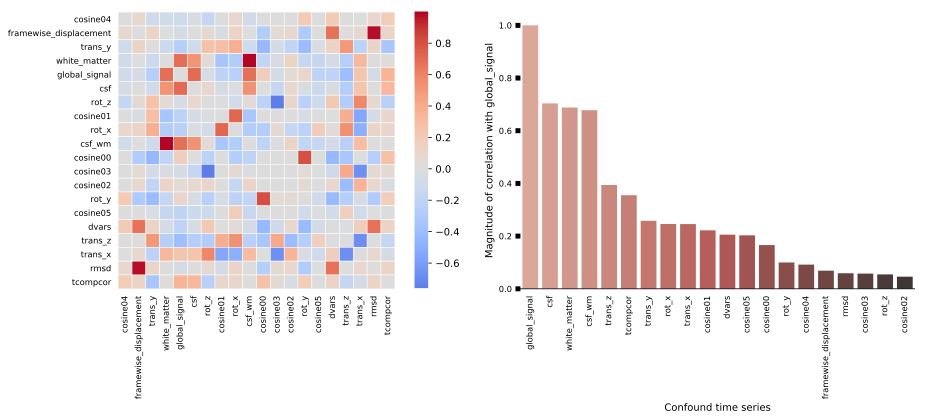

In [16]:
show_svg(svg)

In [13]:

    
def setup_dict(data_dict, sub_ids):
    
    for sub in sub_ids:
        for session in ['ses-1', 'ses-2']:
            #print(sub)
            if sub not in data_dict:
                data_dict[sub] = {'ses-1':{}, 'ses-2':{}}

            for tsv in glob.glob(os.path.join(fmriprep_path, 
                    "{}/{}/func/{}_*training*confounds*.tsv*".format(sub,session, sub))):

                run=tsv.split('/')[-1].split("_")[3]
                data_dict[sub][session][run+"_confound_tsv"] = tsv

        
    return data_dict;
        

In [14]:
fmriprep_path

'/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0'

In [15]:
data_dict={}
data_dict=setup_dict(data_dict, sub_ids)

In [16]:
data_dict.keys()

dict_keys(['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-048', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065', 'sub-066', 'sub-067', 'sub-068', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 'sub-082', 'sub-083', 'sub-084', 'sub-085', 'sub-086', 'sub-087', 'sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-095', 'sub-096',

---
------

## Framewise Displacement(FD) Spikes  


In [17]:
def get_spikes(subject_set, run_list, thres=0.5, comp_pct=0.3):
    
    dataframes=[]
    
    
    for session in ['ses-1', 'ses-2']:
        # loop through subject set
        spike_dict={}
        logf = open("/projects/niblab/experiments/bbx/data/quality_analysis/bbx_%s_FD_spikes_current.txt"%session, "a+")
        for subject in subject_set:
            fail_ct=0
            run_spikes=0
            if subject not in spike_dict:
                spike_dict[subject]={}
            for run in run_list:
                spikes=[]
                try:
                    tsv=data_dict[subject][session][run+"_confound_tsv"]
                    tsv_df = pd.read_csv(tsv, sep='\t')
                    for index,pt in tsv_df['framewise_displacement'].iteritems():
                        if pt > 0.5:
                            spikes.append((round(pt,2), index))

                    spike_ct=len(spikes)

                    spike_dict[subject]['fd_spike_ct_'+run]=spike_ct

                    if spike_ct < int(comp_pct*229):
                        spike_dict[subject]['fd_spike_QC_'+run]='pass'
                    else:
                        run_spikes+=1
                        fail_ct+=1
                        spike_dict[subject]['fd_spike_QC_'+run]='fail'
                        logf.write("{0} {1} Failed FD motion spike check, with a threshold of {2} , spikes found - {3} \n".format(subject+"_"+run,
                                                                                                                                  str(session),
                                                                                                                                 str(thres),
                                                                                                                                 str(spike_ct)))
                    
                except:
                    pass

            spike_dict[subject]['fd_spike_fail_ct']=fail_ct    
            if run_spikes>3:
                spike_dict[subject]['fd_spike_QC']='fail'

            else:
                spike_dict[subject]['fd_spike_QC']='pass'
               
        spike_df=pd.DataFrame(spike_dict).T
        dataframes.append(spike_df)
    return dataframes;

**Get FD spikes from fmriprep confounds**

In [18]:
spike_dict=get_spikes(list(data_dict.keys()), ['run-1', 'run-2','run-3', 'run-4'])

In [19]:
s1_spike_df=spike_dict[0]
s2_spike_df=spike_dict[1]

In [20]:
s1_spike_df.columns.values

array(['fd_spike_ct_run-1', 'fd_spike_QC_run-1', 'fd_spike_ct_run-2',
       'fd_spike_QC_run-2', 'fd_spike_ct_run-3', 'fd_spike_QC_run-3',
       'fd_spike_ct_run-4', 'fd_spike_QC_run-4', 'fd_spike_fail_ct',
       'fd_spike_QC'], dtype=object)

In [21]:
s2_spike_df.columns.values

array(['fd_spike_ct_run-1', 'fd_spike_QC_run-1', 'fd_spike_ct_run-2',
       'fd_spike_QC_run-2', 'fd_spike_ct_run-3', 'fd_spike_QC_run-3',
       'fd_spike_ct_run-4', 'fd_spike_QC_run-4', 'fd_spike_fail_ct',
       'fd_spike_QC'], dtype=object)

In [22]:
# spike_df.style.apply(highlight_cols)

In [23]:
s1_spike_df.head()

,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC
sub-001,5,pass,35,pass,3,pass,3,pass,0,pass
sub-002,1,pass,0,pass,0,pass,2,pass,0,pass
sub-003,2,pass,0,pass,6,pass,1,pass,0,pass
sub-004,27,pass,29,pass,28,pass,44,pass,0,pass
sub-005,3,pass,4,pass,2,pass,3,pass,0,pass


In [24]:
s2_spike_df.head()

,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC
sub-001,1,pass,3,pass,1,pass,0,pass,0,pass
sub-002,0,pass,0,pass,0,pass,0,pass,0,pass
sub-003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pass
sub-004,23,pass,44,pass,45,pass,48,pass,0,pass
sub-005,0,pass,1,pass,2,pass,0,pass,0,pass


### What subjects failed more than 3 runs for session-1?

In [42]:
# get subjects that had 3 or more bad runs
print(s1_spike_df.loc[s1_spike_df['fd_spike_QC']=='fail'].index.values)
display(s1_spike_df.loc[s1_spike_df['fd_spike_QC']=='fail'])
 

['sub-127']


,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC
sub-127,83,fail,74,fail,96,fail,83,fail,4,fail


### What subjects failed more than 3 runs for session-?


In [43]:
# get subjects that had 3 or more bad runs
print(s2_spike_df.loc[s2_spike_df['fd_spike_QC']=='fail'].index.values)
display(s2_spike_df.loc[s2_spike_df['fd_spike_QC']=='fail'])
 

[]


,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC


### What subjects had any failed spike runs in session-1?

In [44]:
# get subjects that failed any runs
print(s1_spike_df[(s1_spike_df == 'fail').any(axis=1)].index.values)
s1_spike_df[(s1_spike_df == 'fail').any(axis=1)]

['sub-031' 'sub-070' 'sub-127' 'sub-133' 'sub-149']


,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC
sub-031,89,fail,55,pass,39,pass,7,pass,1,pass
sub-070,143,fail,69,fail,41,pass,55,pass,2,pass
sub-127,83,fail,74,fail,96,fail,83,fail,4,fail
sub-133,70,fail,27,pass,18,pass,17,pass,1,pass
sub-149,23,pass,34,pass,68,fail,57,pass,1,pass


### What subjects had any failed spike runs in session-2?

In [45]:
## get subjects that failed any runs
print(s2_spike_df[(s2_spike_df == 'fail').any(axis=1)].index.values)
s2_spike_df[(s2_spike_df == 'fail').any(axis=1)]

['sub-070' 'sub-073' 'sub-111' 'sub-116' 'sub-121' 'sub-141' 'sub-156'
 'sub-160']


,fd_spike_ct_run-1,fd_spike_QC_run-1,fd_spike_ct_run-2,fd_spike_QC_run-2,fd_spike_ct_run-3,fd_spike_QC_run-3,fd_spike_ct_run-4,fd_spike_QC_run-4,fd_spike_fail_ct,fd_spike_QC
sub-070,41,pass,47,pass,58,pass,78,fail,1,pass
sub-073,25,pass,49,pass,32,pass,68,fail,1,pass
sub-111,1,pass,14,pass,124,fail,135,fail,2,pass
sub-116,75,fail,105,fail,28,pass,69,fail,3,pass
sub-121,91,fail,67,pass,37,pass,31,pass,1,pass
sub-141,71,fail,56,pass,87,fail,43,pass,2,pass
sub-156,28,pass,62,pass,68,fail,70,fail,2,pass
sub-160,83,fail,79,fail,67,pass,34,pass,2,pass


In [46]:
s2_spike_df.columns.values

array(['fd_spike_ct_run-1', 'fd_spike_QC_run-1', 'fd_spike_ct_run-2',
       'fd_spike_QC_run-2', 'fd_spike_ct_run-3', 'fd_spike_QC_run-3',
       'fd_spike_ct_run-4', 'fd_spike_QC_run-4', 'fd_spike_fail_ct',
       'fd_spike_QC'], dtype=object)

In [27]:
bad_spikes=list(s2_spike_df[(s2_spike_df == 'fail').any(axis=1)].index.values)



## View Bad Spike Files

/projects/niblab/modules/software/miniconda3/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 432x288 with 0 Axes>

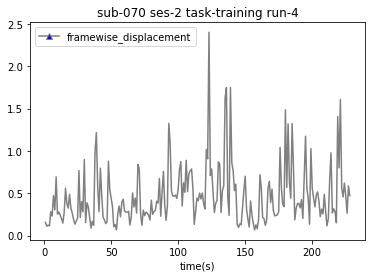

<Figure size 432x288 with 0 Axes>

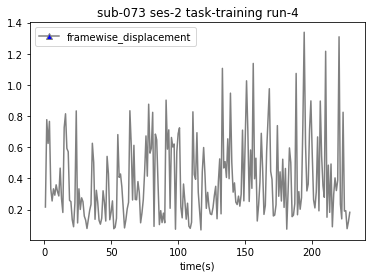

<Figure size 432x288 with 0 Axes>

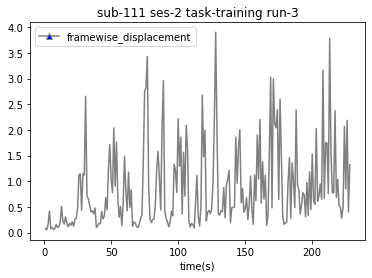

<Figure size 432x288 with 0 Axes>

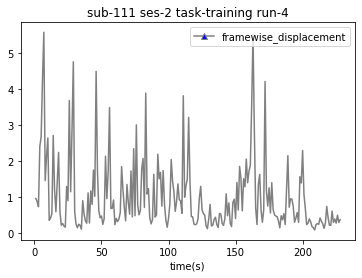

<Figure size 432x288 with 0 Axes>

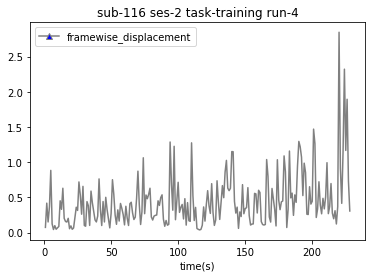

<Figure size 432x288 with 0 Axes>

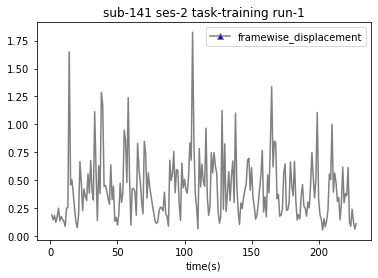

<Figure size 432x288 with 0 Axes>

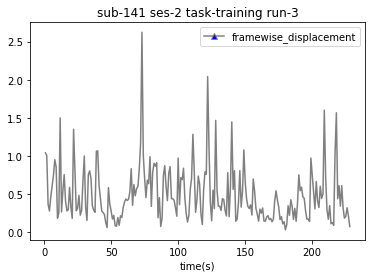

<Figure size 432x288 with 0 Axes>

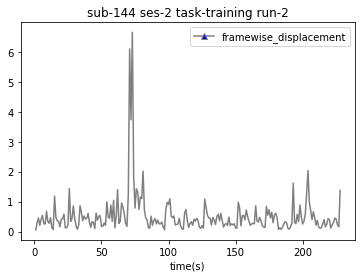

<Figure size 432x288 with 0 Axes>

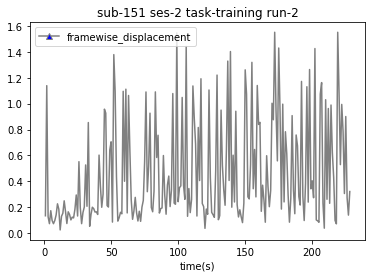

<Figure size 432x288 with 0 Axes>

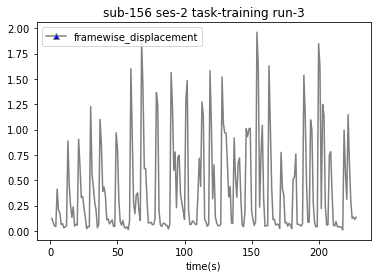

<Figure size 432x288 with 0 Axes>

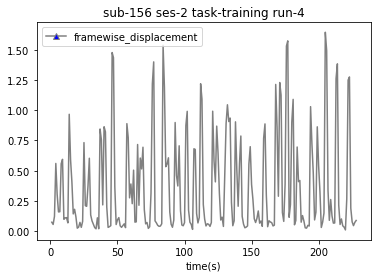

<Figure size 432x288 with 0 Axes>

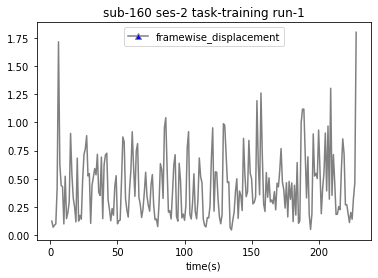

<Figure size 432x288 with 0 Axes>

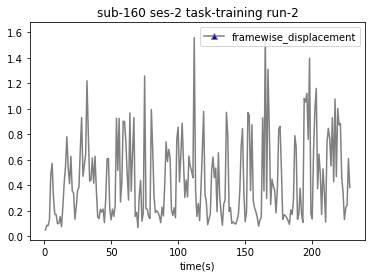

In [28]:
for sub in bad_spikes:
    for x in ['fd_spike_QC_run-1', 'fd_spike_QC_run-2',  'fd_spike_QC_run-3', 'fd_spike_QC_run-4',]:
        if s2_spike_df.loc[sub, x] == 'fail':
            run=x.split("_")[3]
            plt.figure()
            tsv=data_dict[sub]['ses-2'][run+"_confound_tsv"]
            #tsv=os.path.join("/projects/niblab/experiments/bbx/data/fmriprep/{}/ses-1/func/{}_ses-1_task-training_{}_desc-confounds_regressors.tsv".format(subject, subject, run))
            tsv_df = pd.read_csv(tsv, sep='\t')
            tsv_df.rename_axis("time(s)", inplace=True)
            spikes=[]
            markers_on = []
            title="%s %s %s %s"%(sub, 'ses-2', 'task-training', run)
            tsv_df.plot.line( y="framewise_displacement",marker='^',markerfacecolor='b',
                             markevery=markers_on, c="gray", use_index=True, title=title)

### Write Files

In [60]:
#path='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-trimmed_report.xlsx'
path='/projects/niblab/experiments/bbx/data/quality_analysis/bbx_fmri_data_report.xlsx'

In [61]:
writer = pd.ExcelWriter(path, engine = 'openpyxl')
book = load_workbook(path)
writer.book = book
s1_spike_df.to_excel(writer, sheet_name="ses-1_fd_confounds")
s2_spike_df.to_excel(writer, sheet_name="ses-2_fd_confounds")
writer.save()
writer.close()

---
---

  ## Regressor Extraction
  ---

> ### Plots

In [25]:
def regressor_plots(subject='sub-001',session='ses-1',run="run-1"):

    plt.figure()
    tsv=data_dict[subject][session][run+"_confound_tsv"]
    #tsv=os.path.join("/projects/niblab/experiments/bbx/data/fmriprep/{}/ses-1/func/{}_ses-1_task-training_{}_desc-confounds_regressors.tsv".format(subject, subject, run))
    tsv_df = pd.read_csv(tsv, sep='\t')
    tsv_df.rename_axis("time(s)", inplace=True)
    spikes=[]
    markers_on = []
    
    confoundcorr_svg='/projects/niblab/experiments/bbx/data/fmriprep_data/fmriprep_trimmed/%s/ses-1/figures/%s_ses-1_task-training_%s_desc-confoundcorr_bold.svg'%(subject,subject, run) 
    carpetplot='/projects/niblab/experiments/bbx/data/fmriprep_data/fmriprep_trimmed/%s/ses-1/figures/%s_ses-1_task-training_%s_desc-carpetplot_bold.svg'%(subject,subject, run) 
    compcorvar='/projects/niblab/experiments/bbx/data/fmriprep_data/fmriprep_trimmed/%s/ses-1/figures/%s_ses-1_task-training_%s_desc-compcorvar_bold.svg'%(subject,subject, run)

    for index,pt in tsv_df['framewise_displacement'].iteritems():
        if pt > 0.5:
            spikes.append((round(pt,2), index))

    spike_ct=len(spikes)

    
    try:
        show_svg(confoundcorr_svg)
        show_svg(carpetplot)
        show_svg(compcorvar)
    except:
        pass
    
    
    if spike_ct != 0:
        for x in spikes:
            markers_on.append(x[1])

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,13))
    fig.subplots_adjust(hspace=.5)

    ax[1,0].axhline(y=0.5, color='black', linestyle='--')

    tsv_df.plot.line( y="trans_x", use_index=True, ax=ax[0,0])
    tsv_df.plot.line( y="trans_y", use_index=True, ax=ax[0,0])
    tsv_df.plot.line( y="trans_z", use_index=True, ax=ax[0,0])
    tsv_df.plot.line( y="rot_x", use_index=True, ax=ax[0,1])
    tsv_df.plot.line( y="rot_y", use_index=True, ax=ax[0,1])
    tsv_df.plot.line( y="rot_z", use_index=True, ax=ax[0,1])
    tsv_df.plot.line( y="framewise_displacement",marker='^',markerfacecolor='b',
                     markevery=markers_on, c="gray", use_index=True, ax=ax[1,0])

    for acompcor in acompcor_cols:
        tsv_df.plot.line( y=acompcor, use_index=True, ax=ax[1,1])


    #acompcor_df=tsv_df.loc[:,acompcor_cols]

    # Compute the correlation matrix
    #df_corr = acompcor_df.corr()

    # Generate a mask for the upper triangle
    #mask = np.triu(np.ones_like(df_corr, dtype=bool))
    # adjust mask and df
    #mask = mask[1:, :-1]
    #corr = df_corr.iloc[1:,:-1].copy()

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
     #  linewidths=5, cmap=cmap, vmin=-1, vmax=1, cbar_kws={"shrink": .8}, square=True, ax=ax[1,1])


    ax[0,0].set_title("Translation")
    ax[0,1].set_title("Rotation")
    ax[1,0].set_title("Framewise Displacement")
    ax[1,1].set_title("aCompCor Regressors")   
    plt.show()


In [33]:
w_motion = widgets.Select(options=sub_ids, run=['run-1','run-2','run-3','run-4'])
widgets.interactive(regressor_plots, subject=w_motion, run=['run-1','run-2','run-3','run-4'])

interactive(children=(Select(description='subject', options=('sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-…

---  
### Create Regressor Files

In [23]:
def highlight_greaterthan(x):
    if x > 0:
        return ['background-color: yellow']
    else:
        return ['background-color: white'] 


def prepare_basic_confounds(tsv, write_files=True, makedir=False, verbose=True):
    
    
    if 'resting' not in tsv:
        sub=tsv.split("/")[-1].split("_")[0]
        session=tsv.split("/")[-1].split("_")[1]
        if "resting" in tsv:
            run = ""
            task="task-resting"
        else:
            run=tsv.split("/")[-1].split("_")[3]+"_"
            task="task-training"
            
            

        # get mocos // edit any timepoints here 
        df=pd.read_csv(tsv, sep="\t")
        
        # grab the confound columns
        six_mocos=df.loc[:,['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']] 
        
        # write files
        if write_files == True: 

            # write to files
            out_folder=os.path.join(datapath, 
                                    'preprocessed/confounds_trimmed/basic_head_confounds')
            
            
            # setup the outpaths
            moco0_out=os.path.join(out_folder, "%s_%s_%s_%smoco0.tsv"%(sub, session,task, run))
            moco1_out=os.path.join(out_folder, "%s_%s_%s_%smoco1.tsv"%(sub, session,task, run))
            moco2_out=os.path.join(out_folder, "%s_%s_%s_%smoco2.tsv"%(sub, session,task, run))
            moco3_out=os.path.join(out_folder, "%s_%s_%s_%smoco3.tsv"%(sub, session,task, run))
            moco4_out=os.path.join(out_folder, "%s_%s_%s_%smoco4.tsv"%(sub, session,task, run))
            moco5_out=os.path.join(out_folder, "%s_%s_%s_%smoco5.tsv"%(sub, session,task, run))

            
            # # write basic head motion confounds
            six_mocos['trans_x'].to_csv(moco0_out, index=False, header=False)
            six_mocos['trans_y'].to_csv(moco1_out, index=False, header=False)
            six_mocos['trans_z'].to_csv(moco2_out, index=False, header=False)
            six_mocos['rot_x'].to_csv(moco3_out, index=False, header=False)
            six_mocos['rot_y'].to_csv(moco4_out, index=False, header=False)
            six_mocos['rot_z'].to_csv(moco5_out, index=False, header=False)


        else:
            pass
            
###############################################################################################################



def fsl_fd_outliers(func_file):
    """
    # Run fsl_motion_outliers by passing in a function file
    """
    #print(func_file)
    
    # Set variables
    outpath=os.path.join(confound_path,'fsl_fd_spikes')
    filename = func_file.split(".")[0]
    confound_filename = os.path.join(outpath, '%s_fd_spikes.txt'%filename.split("/")[-1])
    plotpt_filename = os.path.join(outpath,'%s_moco.png'%filename.split("/")[-1])
    moco_cmd = ['fsl_motion_outliers', '-i', func_file, '-o', confound_filename, '-p', plotpt_filename, '--fd', '--thresh=0.5', '-v']
    outlier_txt = os.path.join(outpath, 'outliers_output.txt')
    
    #print(confound_filename)
    #outhtml = "/projects/niblab/experiments/bbx/data/test/prepro_pipeline/bold_motion_QA.html"
    if not os.path.exists(confound_filename):
        try:
            with open(outlier_txt, 'w') as txtf:
                # run fsl_motion_outiers command
                moco_process=subprocess.Popen(moco_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True) 
                #if verbose ==True:
                #print('[INFO] running command: \n', ' '.join(moco_cmd))
                stdout, stderr = moco_process.communicate()
                moco_process.wait()
                txtf.write(stdout)
            txtf.close()

            confound_file=os.path.join(confound_filename)
            #print("[INFO] confound file outpath: %s"%confound_file)
            if not os.path.exists(confound_file):
                touch_cmd=["touch", "%s"%(confound_file)]
                #print('[INFO] making empty confound file with command: ', ' '.join(touch_cmd))
                subprocess.run(touch_cmd)

            confound_output = subprocess.check_output("grep -o 1 %s | wc -l"%(confound_file), shell=True)

            num_scrub = [int(s) for s in confound_output.split() if s.isdigit()]

            vol = subprocess.check_output(["fslnvols", func_file])
            vol=str(vol,'utf-8').strip("\n")
            vol_check=int(vol)*.25

            out_bad_bold_list = os.path.join('/projects/niblab/experiments/bbx/data/quality_analysis/bbx_ses-1_vol_scrub.txt')
            if num_scrub[0]>vol_check:
                print('[INFO] writing to scrub list')
                with open(out_bad_bold_list, "a") as myfile:
                    myfile.write("%s\n"%(func_file))

        except Exception as e:
            print('[INFO] error: ', e)
    else: 
        pass


###############################################################################################################
    
def regressor_files(create_acomp=False, create_fd_spike=False, fsl_fd=False, mocos=False):
    """
    # Make Regressor Files
    """

    if create_acomp==True:
        logf= open(os.path.join(bbx_path, "code/preprocessing", "acompcor_current.log"), "a+")
        acompcor_cols=['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
                            'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']
        for sub in sub_ids:
            
            for ses in data_dict[sub]:
                for key in data_dict[sub][ses]:
                    tsv=data_dict[sub][ses][key]
                    df=pd.read_csv(tsv, sep="\t")

                    try:
                        acomp_vals=df.loc[:, acompcor_cols]

                           
                        run=key.split("_")[0]
                        if "run" in run:
                            for acompcor in acompcor_cols:

                                acompcor_df=df.loc[:,[acompcor]]

                                if len(acompcor_df.index.values) != 229:
                                    print(tsv)
                                    #display(acompcor_df.tail())
                                    


                                acompcor_outfile=os.path.join(confound_path,
                                                              'acompcor',
                                                              '%s_%s_task-training_%s_%s.txt'%(sub, ses, run, acompcor))

                                if os.path.exists(acompcor_outfile):
                                    pass
                                else:
                                    acompcor_df.to_csv(acompcor_outfile, index=False, header=None)
                        else:
                            print('passing %s %s'%(sub, ses))
                            pass
                            

                    except Exception as e:
                        #print(e)
                        logf.write("Failed to download {0}: {1}\n".format(str(tsv), str(e)))
        logf.close()
        print('[INFO] completed writing acompcor files')

        
        


    if create_fd_spike==True:
        for sub in sub_ids:
            for ses in data_dict[sub]:
                for key in data_dict[sub][ses]:
                    tsv=data_dict[sub][ses][key]
                    df=pd.read_csv(tsv, sep="\t")
                    fd_vals=df.loc[:,['framewise_displacement']]
                    run=key.split("_")[0]
                    spike_dict={}
                    spikes=[]
                    spike_num=0
                    if 'run' in run:
                        for index,pt in df['framewise_displacement'].iteritems():
                            if pt > 0.5:
                                try:
                                    spike_num+=1
                                    temp_list=[0 for _ in range(229)]
                                    temp_list2=[0 for _ in range(229)]

                                    #print(spike_num)

                                    spikes.append((round(pt,2), index))


                                    temp_list[index]=1
                                    spike_dict['spike%s'%spike_num] = temp_list

                                    if index != 228:
                                        if df.loc[index+1, 'framewise_displacement'] < 0.5:
                                            temp_list2[index+1]=1
                                            spike_dict['post-spike%s'%spike_num] = temp_list2

                                except Exception as e:
                                    # WRITE TO LOGFILE
                                    pass
                                    #print(e)
                                    #print(index, pt)
                                    #print(ses)
                    else:
                        pass

                    spike_ct=len(spikes)
                    spikes_df=pd.DataFrame(spike_dict)


                    comparator=.25*229
                    comparator=int(comparator)

                    df['fd_spikes'] = df['framewise_displacement'].gt(0.5).astype(int)                

                    fdspikes_outfile=os.path.join(confound_path,
                          'fmriprep_fd_spikes/%s_%s_task-training_%s_fd_spikes.txt'%(sub,ses, run))
                    
                    if os.path.exists(fdspikes_outfile):
                        pass
                    else:
                        spikes_df.to_csv(fdspikes_outfile, index=False, header=None, sep="\t" )
                        
        print('[INFO] completed writing fd spike files')
            

    if fsl_fd==True:
        for sub in sub_ids[:5]:
            for key in data_dict[sub]:
                moco_funcs=glob.glob(os.path.join(bids_path, '%s/ses-1/func/*training*.nii.gz'%sub))
        
                agents=5
                chunksize=4
                with Pool(processes=agents) as pool:
                    pool.map(fsl_fd_outliers, moco_funcs)

        print('[INFO] completed writing FSL FD files')
        
        
    if mocos==True:
        
        logf = open("/projects/niblab/experiments/bbx/code/basic_confounds_current.log", "a+")
        for sub in sub_ids:
            for ses in data_dict[sub]:
                for key in data_dict[sub][ses]: 
                    tsvs=glob.glob(os.path.join(fmriprep_path, 
                                                '%s/%s/func'%(sub, ses),
                                                '*training*confounds*.tsv'))

                    try:
                        agents=5
                        chunksize=10
                        with Pool(processes=agents) as pool:
                            pool.map(prepare_basic_confounds, tsvs)
                        #prepare_basic_confounds()

                    except Exception as e:
                        logf.write("Failed to download {0}: {1}\n".format(str(tsv), str(e)))
        logf.close()
        print('[INFO] completed writing basic motion confounds')


In [24]:
st = time.time()
regressor_files(create_acomp=True, create_fd_spike=True, mocos=True,  fsl_fd=False)
process_time = st - time.time()
print("[INFO] process time ~ %s seconds"%process_time)

/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed-20.2.0/sub-150/ses-2/func/sub-150_ses-2_task-training_run-1_desc-confounds_timeseries.tsv
[INFO] completed writing acompcor files
[INFO] completed writing fd spike fi

In [ ]:
logf= open(os.path.join(bbx_path, "code/preprocessing", "acompcor_current.log"), "a+")
acompcor_cols=['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02',
                    'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05']
for sub in sub_ids[:10]:

    for ses in data_dict[sub]:
        for key in data_dict[sub][ses]:
            tsv=data_dict[sub][ses][key]
            df=pd.read_csv(tsv, sep="\t")

            try:
                acomp_vals=df.loc[:, acompcor_cols]


                run=key.split("_")[0]
                if "run" in run:
                    for acompcor in acompcor_cols:

                        acompcor_df=df.loc[:,[acompcor]]

                        if len(acompcor_df.index.values) != 229:
                            print(tsv)
                            display(acompcor_df.tail())



                        acompcor_outfile=os.path.join(confound_path,
                                                      'acompcor',
                                                      '%s_%s_task-training_%s_%s.txt'%(sub, ses, run, acompcor))

                        if os.path.exists(acompcor_outfile):
                            pass
                        else:
                            acompcor_df.to_csv(acompcor_outfile, index=False, header=None)
                else:
                    print('passing %s %s'%(sub, ses))
                    pass


            except Exception as e:
                #print(e)
                logf.write("Failed to download {0}: {1}\n".format(str(tsv), str(e)))
logf.close()
print('[INFO] completed writing acompcor files')

### Make feat1 folder

In [35]:
for sub in sub_ids:
    
    fsl_folder=os.path.join(datapath, 'preprocessed/subs_trimmed', sub, 'ses-2', 'fsl_feat1')
    if os.path.exists(fsl_folder):
        pass
    else:
        print("[INFO] making folder....%s"%fsl_folder)
        os.makedirs(fsl_folder)

---

---